# GSoc TRIP Test Project: 
Advancing Transportation Safety through AI

## Objective: 

Explore machine learning and AI to enhance the analysis of data collected by a high-fidelity driving simulator and integrated eye tracking


#### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2  # For video processing
import numpy as np
import dlib

#### Load and Inspect Data

In [ ]:
VIDEO_DATA = 'Experimenter_9110002_53.mp4'
DAT_DATA = 'Experimenter_9110002_53.dat'

In [3]:
# Load the data from the .dat file
data = pd.read_csv(DAT_DATA, delimiter=' ') 

# Display the first few rows of the dataset
print(data.head())

   DatTime  SimTime  MediaTime  LonAccel  LatAccel  Throttle  Brake  Gear  \
0    0.016        0   0.133333  0.000448  0.001680  1.308809    0.0   0.0   
1    0.033        0   0.133333  0.000700  0.018673  1.308809    0.0   0.0   
2    0.049        0   0.166666  0.000808  0.030992  1.308809    0.0   0.0   
3    0.065        0   0.166666  0.000791  0.037267  1.308809    0.0   0.0   
4    0.082        0   0.200000  0.000659  0.037458  1.308809    0.0   0.0   

      Heading  HeadwayDistance  ...  BoxStatus  ResponseButton  \
0  359.999687        91.047424  ...        0.0             0.0   
1  359.999555        91.046936  ...        0.0             0.0   
2  359.999391        91.045715  ...        0.0             0.0   
3  359.999225        91.044128  ...        0.0             0.0   
4  359.999085        91.042297  ...        0.0             0.0   

   CriticalEventStatus  FRAME_NUM  FILTERED_GAZE_OBJ_NAME  \
0                  0.0          .                       .   
1                 

#### Data Exploration

In [4]:
# Explore the dataset
print(data.columns)

# Check for missing values
print(data.isnull().sum())


Index(['DatTime', 'SimTime', 'MediaTime', 'LonAccel', 'LatAccel', 'Throttle',
       'Brake', 'Gear', 'Heading', 'HeadwayDistance', 'HeadwayTime', 'Lane',
       'LaneOffset', 'RoadOffset', 'Steer', 'Velocity', 'XPos', 'YPos',
       'BLINKING', 'BLINKID', 'LEFTEYELIDSTATE', 'RIGHTEYELIDSTATE',
       'LeadVehPosX', 'LeadVehPosY', 'BoxPosX', 'BoxPosY', 'BoxPosZ',
       'FollowCarBrakingStatus', 'BoxStatus', 'ResponseButton',
       'CriticalEventStatus', 'FRAME_NUM', 'FILTERED_GAZE_OBJ_NAME',
       'ESTIMATED_CLOSEST_WORLD_INTERSECTION', 'REALTIME_CLOCK', 'hiFileTime',
       'lowFileTime', 'Unnamed: 37'],
      dtype='object')
DatTime                                     0
SimTime                                     0
MediaTime                                   0
LonAccel                                    0
LatAccel                                    0
Throttle                                    0
Brake                                       0
Gear                                    

In [5]:
# Remove the 'Unnamed: 37' column
data.drop('Unnamed: 37', axis=1, inplace=True)

In [6]:
# Convert time columns to appropriate format if necessary
data['DatTime'] = pd.to_datetime(data['DatTime'])
data['SimTime'] = pd.to_datetime(data['SimTime'])
data['MediaTime'] = pd.to_datetime(data['MediaTime'])


#### Data Pre-processing

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardization
standard_scaler = StandardScaler()
data[['LonAccel', 'LatAccel', 'Velocity', 'Throttle', 'Brake']] = standard_scaler.fit_transform(data[['LonAccel', 'LatAccel', 'Velocity', 'Throttle', 'Brake']])

# Normalization 
min_max_scaler = MinMaxScaler()
data[['LonAccel', 'LatAccel', 'Velocity', 'Throttle', 'Brake']] = min_max_scaler.fit_transform(data[['LonAccel', 'LatAccel', 'Velocity', 'Throttle', 'Brake']])


#### Feature Engineering

In [8]:
# Convert SimTime differences to seconds (assuming SimTime is in a datetime format)
data['SimTimeDiff'] = data['SimTime'].diff().dt.total_seconds()

# Ensure there are no NaN or 0 values to avoid division errors
data['SimTimeDiff'].replace(0, 1, inplace=True)  # replace 0 with 1 to avoid division by zero

# Now calculate the AccelRate
data['AccelRate'] = data['Velocity'].diff() / data['SimTimeDiff']

# Overall Acceleration (sqrt of the sum of squares of LonAccel and LatAccel)
data['OverallAccel'] = np.sqrt(data['LonAccel']**2 + data['LatAccel']**2)

# Lane Deviation (absolute lane offset might be a simple measure)
data['LaneDeviation'] = data['LaneOffset'].abs()

/var/folders/z8/_vvjvjp17jx590_gh4qpr1z40000gn/T/ipykernel_33890/4185685478.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['SimTimeDiff'].replace(0, 1, inplace=True)  # replace 0 with 1 to avoid division by zero


### Driver Risk Assessment Documentation

#### Overview

Our Driver Risk Assessment model is an advanced analytical tool designed to quantify the risk level of a driver's behavior during a simulated driving scenario. By integrating a series of kinematic and behavioral parameters, the model offers a comprehensive evaluation of potential driving hazards.

#### Methodology

The assessment is based on four key indicators of driving behavior, known to contribute to overall driving risk:

- **High Speed**: Evaluating instances where the vehicle's velocity exceeds a threshold determined by the 85th percentile of the observed velocity distribution. This percentile was chosen to capture speeds higher than those of typical driving conditions while excluding extreme outliers.

- **Sudden Braking**: Identifying moments of abrupt deceleration, a potential indicator of reactive driving, which can be a sign of risk. The threshold is set at the 99th percentile of the absolute change in brake pressure between successive observations.

- **Erratic Steering**: Monitoring the vehicle's steering behavior to pinpoint erratic movements. The threshold for what constitutes 'erratic' is the 99th percentile of the absolute change in steering angle, capturing significant deviations from smooth steering patterns.

- **Lane Deviation**: Recognizing significant deviations from the lane center, which could lead to safety concerns. The measure uses an Interquartile Range (IQR) method to set a threshold, where any lane offset beyond 1.5 times the IQR from the third quartile (upper whisker of the data) is considered a lane deviation.

#### Quantification Process

Each occurrence of the aforementioned behaviors increments the driver's risk score:

- A binary flag for each risk indicator is set to true when its respective threshold is exceeded.
- These flags are then summed to create a composite `RiskScore` for each observation point within the driving data.
- The overall risk score is aggregated across the dataset to provide a single risk metric.

#### Results

- The cumulative `RiskScore` across all observations provides insight into the prevalence and frequency of risky driving behaviors.
- For the analyzed dataset, the Total Risk Score is calculated to be 4744, reflecting the aggregate measure of risk throughout the simulation period.


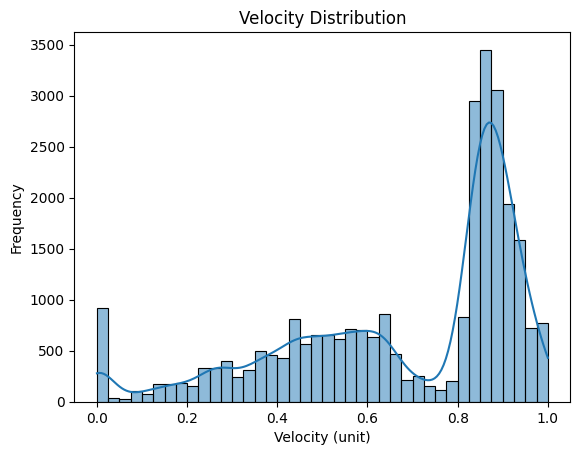

In [9]:
import seaborn as sns

sns.histplot(data['Velocity'], kde=True)
plt.title('Velocity Distribution')
plt.xlabel('Velocity (unit)')
plt.ylabel('Frequency')
plt.show()

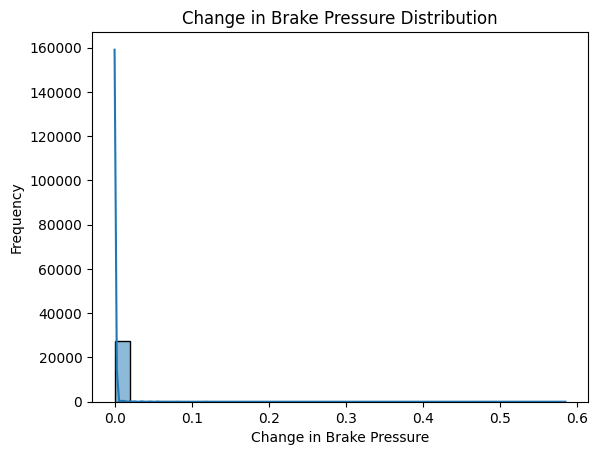

In [10]:
sns.histplot(data['Brake'].diff().abs(), kde=True, bins=30)
plt.title('Change in Brake Pressure Distribution')
plt.xlabel('Change in Brake Pressure')
plt.ylabel('Frequency')
plt.show()


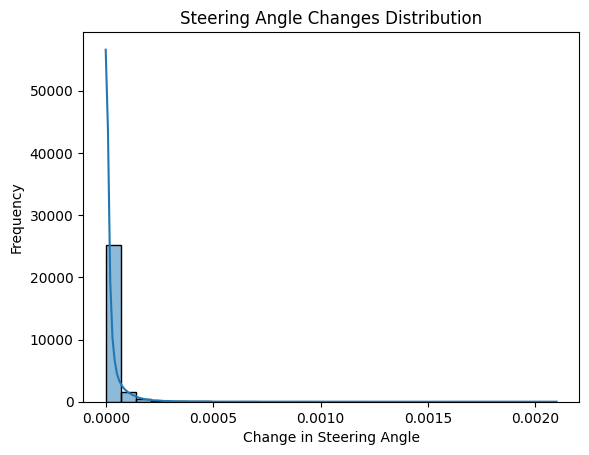

In [11]:
sns.histplot(data['Steer'].diff().abs(), kde=True, bins=30)
plt.title('Steering Angle Changes Distribution')
plt.xlabel('Change in Steering Angle')
plt.ylabel('Frequency')
plt.show()


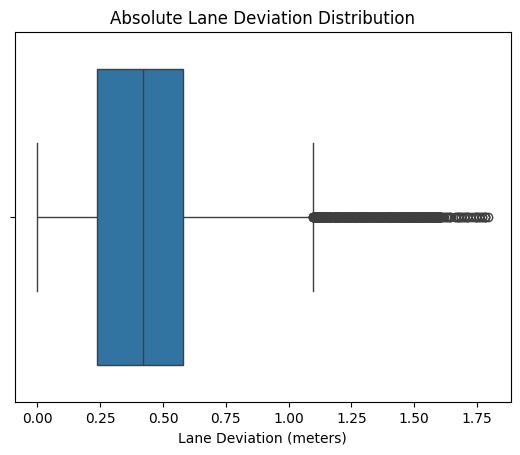

In [12]:
sns.boxplot(x=data['LaneOffset'].abs())
plt.title('Absolute Lane Deviation Distribution')
plt.xlabel('Lane Deviation (meters)')
plt.show()


In [23]:
high_speed_threshold = np.percentile(data['Velocity'], 85)
sudden_brake_threshold = np.percentile(data['Brake'].diff().abs(), 99)
erratic_steering_threshold = np.percentile(data['Steer'].diff().abs(), 99)

# Calculate the IQR
Q3 = np.percentile(data['LaneOffset'].abs(), 75)
Q1 = np.percentile(data['LaneOffset'].abs(), 25)
IQR = Q3 - Q1

# Determine the end of the upper whisker
upper_whisker = Q3 + 1.5 * IQR

# Any value beyond this might be considered as a lane deviation that could indicate risky behavior.
lane_deviation_threshold = upper_whisker

#### Calculating Risk Indicators

In [24]:
# High Speed
data['HighSpeed'] = data['Velocity'] > high_speed_threshold

# Sudden Braking
data['SuddenBraking'] = data['Brake'].diff().abs() > sudden_brake_threshold

# Erratic Steering
data['ErraticSteering'] = data['Steer'].diff().abs() > erratic_steering_threshold

# Lane Deviation
data['LaneDeviation'] = data['LaneOffset'].abs() > lane_deviation_threshold


#### Aggregating Risk Score

In [25]:
data['RiskScore'] = data[['HighSpeed', 'SuddenBraking', 'ErraticSteering', 'LaneDeviation']].sum(axis=1)


In [26]:
# Convert SimTimeDiff to cumulative seconds
data['CumulativeTime'] = data['SimTimeDiff'].cumsum()

# Calculate the total risk score up to that index
total_risk_score = data.loc[:, 'RiskScore'].sum()

print(f"Total Risk Score is: {total_risk_score}")

Total Risk Score is: 4744


### Drowsiness Detection and Attentiveness Checking in Video Analysis

#### How It Works

Our system processes video footage frame-by-frame, applying advanced computer vision techniques to detect and analyze facial features, focusing on two key aspects: drowsiness detection and attentiveness checking.

#### Drowsiness Detection

- **Face and Eye Detection**: The system first identifies human faces in each frame. Using dlib's facial landmark detection technology, it then locates key facial landmarks, with a particular focus on the eyes.

- **Eye Aspect Ratio (EAR) Analysis**: A crucial part of the process is calculating the 'Eye Aspect Ratio' or EAR. This geometric measure, derived from the eye landmarks, helps in determining how open or closed the eyes are.

- **Drowsiness Indication**: The system uses a predefined EAR threshold to judge if an eye is considered to be 'closed' or 'nearly closed.' An EAR below this threshold indicates that the eyes are closed to a degree, suggesting potential drowsiness or fatigue.

- **Quantification and Alerts**: The system quantifies the frequency of drowsiness signs detected within the first five minutes of the video. It provides an overall drowsiness frequency score and generates on-screen alerts for immediate visual feedback when drowsiness is detected.

#### Attentiveness Checking

- **Simplified Face Detection**: For attentiveness, the system periodically checks for the presence of faces within the video frames. The absence of a face over several intervals may imply inattentiveness.

- **Time-Specific Analysis**: This check is performed specifically for the initial five minutes of the video, providing a focused assessment of attentiveness during this critical period.

- **Attentiveness Score**: Similar to drowsiness detection, the system calculates an attentiveness score based on the frequency of face detection in the first five minutes, offering a quantitative measure of the subject's attentiveness.

#### Interactive Display

- The system visually highlights important facial regions, such as the eyes for drowsiness detection and the overall face for attentiveness checks, in real-time. This interactive display aids in understanding what the system is analyzing at any moment.


#### Face and Eye Tracking

In [27]:
# Load the face and eye cascade classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [28]:
# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
p = "./shape_predictor_68_face_landmarks.dat"  
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

# Define a function to calculate EAR given eye landmarks
def calculate_ear(eye_points):
    # Calculate the distances between the two sets of vertical eye landmarks (x, y)-coordinates
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])

    # Calculate the distance between the horizontal eye landmark (x, y)-coordinates
    C = np.linalg.norm(eye_points[0] - eye_points[3])

    # Compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)

    return ear

In [29]:
# EAR threshold for blink detection; I will need to calibrate this
EAR_THRESHOLD = 0.3

In [30]:
def detect_drowsiness(frame, detector, predictor):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 0)
    drowsiness_detected = False  # Flag to indicate if drowsiness is detected in the frame

    for face in faces:
        shape = predictor(gray, face)
        shape = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)])

        leftEye = shape[42:48]
        rightEye = shape[36:42]

        leftEAR = calculate_ear(leftEye)
        rightEAR = calculate_ear(rightEye)
        ear = (leftEAR + rightEAR) / 2.0

        if ear < EAR_THRESHOLD:
            drowsiness_detected = True
    
    return drowsiness_detected

# Process the first 5 minutes of the video
video_capture = cv2.VideoCapture(VIDEO_DATA)
fps = video_capture.get(cv2.CAP_PROP_FPS)
total_frames = int(5 * 60 * fps)  # 5 minutes
drowsiness_count = 0

for _ in range(total_frames):
    ret, frame = video_capture.read()
    if not ret:
        break

    if detect_drowsiness(frame, detector, predictor):
        drowsiness_count += 1

video_capture.release()

# Calculate drowsiness frequency
drowsiness_frequency = drowsiness_count / total_frames
print(f"Drowsiness Frequency: {drowsiness_frequency}")


KeyboardInterrupt: 

In [31]:
def simple_attentiveness_check(video_path, face_cascade, interval=30, duration=300):
    video_capture = cv2.VideoCapture(video_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(min(duration * fps, video_capture.get(cv2.CAP_PROP_FRAME_COUNT)))
    frame_count = 0
    face_detected_count = 0

    while frame_count < total_frames:
        ret, frame = video_capture.read()
        if not ret:
            break

        # Check for faces every 'interval' frames
        if frame_count % interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                face_detected_count += 1

        frame_count += 1

    video_capture.release()
    attentiveness_score = face_detected_count / (total_frames / interval)
    return attentiveness_score

# Usage
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
attentiveness_score = simple_attentiveness_check(VIDEO_DATA, face_cascade)
print(f"Attentiveness Score: {attentiveness_score}")

KeyboardInterrupt: 

### Environmental Risk Quantification Using Pre-trained YOLO Model

#### Overview

To enhance driving safety and performance in simulated environments, I have integrated an environmental risk quantification module using the state-of-the-art YOLO (You Only Look Once) object detection system. This system utilizes a pre-trained model to detect and assess potential hazards within the simulation.

#### Model Specification

- **Model**: YOLOv3
- **Training Data**: COCO (Common Objects in Context) Dataset
- **Input**: Video frames from driving simulation
- **Output**: Detection of various objects such as vehicles, pedestrians, and traffic signs with associated risk scores

#### Object Detection Process

1. **Pre-processing**:
   Each frame from the driving simulation video is resized and normalized to prepare for object detection.

2. **Detection**:
   The YOLO network processes the pre-processed frames to detect objects. For each object detected, the model returns the class, confidence score, and bounding box coordinates.

3. **Post-processing**:
   Non-maximum suppression is applied to the detections to filter out overlapping boxes and retain the most accurate bounding boxes for each object.

#### Risk Assessment

- Each detected object is assigned a risk score based on pre-defined criteria that take into account the type of object and its relevance to driving safety. For instance, vehicles such as cars, trucks, and buses are scored differently from pedestrians.
- The scores are cumulative, and a total environmental risk score is calculated for the duration of the video or simulation.

#### Output

- The module outputs a numerical `Environmental Risk Score`, representing the total quantified risk for the simulated driving session.
- The risk score provides insights into potential hazards and the safety of the simulated environment, aiding in the development of risk mitigation strategies.

#### Applications

- **Driver Training**: To educate drivers about potential hazards they may encounter and improve their risk response strategies.
- **Simulation Enhancement**: To refine the simulated environment by incorporating realistic risk factors and improving the effectiveness of the simulation.



In [ ]:

# Load YOLO
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Loading the COCO class labels our YOLO model was trained on
classes = open('coco.names').read().strip().split('\n')

# Function to get detections
def get_detections(frame):
    height, width, channels = frame.shape
    # Detecting objects
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confidences, class_ids

# Process the video
video_capture = cv2.VideoCapture(VIDEO_DATA)
risk_score = 0

while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    boxes, confidences, class_ids = get_detections(frame)
    
    # Apply non-max suppression to boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    # Quantify risk based on detections
    for i in range(len(boxes)):
        if i in indexes:
            label = str(classes[class_ids[i]])
            if label in ['car', 'truck', 'bus']:
                risk_score += 3  # Adjust scores as per requirement
            elif label == 'person':
                risk_score += 5  # Pedestrians add more risk
            # Add more conditions for other classes as needed

video_capture.release()

print(f"Environmental Risk Score: {risk_score}")



### Documentation for Annotated Video Output


#### Process

- **Detection**: As the simulated driving video is played, the YOLO object detection model scans each frame to identify objects, classify them, and determine their location within the frame.
- **Annotation**: Identified objects are outlined with bounding boxes. Labels and confidence levels are provided to inform users of the type of object detected and the model's certainty regarding its presence.
- **Visualization**: Annotated frames are displayed in real-time, offering an immediate visual reference to augment the driver's awareness of their surroundings.

#### Output

The output is an annotated video stream where every object deemed potentially risky or attention-worthy is highlighted. This feature is particularly useful for:
- **Safety Analysis**: By reviewing the annotated video, safety analysts can identify moments where the driver or the simulated environment introduces risk.
- **Driver Training**: Trainee drivers can use the annotated video as a learning tool to understand which objects and scenarios require careful attention while driving.




In [ ]:
# Load YOLO
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Loading the COCO class labels our YOLO model was trained on
classes = open('coco.names').read().strip().split('\n')

# Initialize the video capture
video_capture = cv2.VideoCapture(VIDEO_DATA)

while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    # Perform the object detection (implementation of detect_objects is provided earlier)
    boxes, confidences, class_ids = detect_objects(frame, net, output_layers)

    # Apply non-max suppression to boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw the boxes and label the objects
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0) # Green color for the boxes
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the frame with annotations
    cv2.imshow('Frame with Annotations', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close OpenCV windows
video_capture.release()
cv2.destroyAllWindows()


### Driver Behavior Prediction Model with Overfitting Analysis


#### Data and Features

- **Input Data**: Key kinematic and behavioral parameters from simulation data, such as `Velocity`, `AccelRate`, `Brake` pressure, `Steer` angle, and `LaneDeviation`.
- **Target Variable**: The `RiskScore`, a computed metric based on the input features, quantifies the risk level of driving behavior.

#### Model Training, Evaluation, and Overfitting Concern

1. **Training Process**:
   - The dataset is split into 70% training and 30% testing sets.
   - The RandomForestRegressor model is then trained on the training set.

2. **Evaluation Metrics**:
   - **Mean Squared Error (MSE)** and **R² Score** are used to evaluate model accuracy and fit.
   - **Cross-Validation** with 5-fold cross-validation using negative mean squared error assesses generalization.

3. **Overfitting Analysis**:
   - Exceptionally high accuracy metrics (near-zero MSE and R² Score close to 1) suggest potential overfitting.
   - A key contributing factor could be the `RiskScore` itself, which is derived directly from features like speed and lane deviation. This close relationship between features and target variable could lead to the model learning to replicate the formula used to compute the `RiskScore` rather than generalizing from underlying driving behavior.

#### Recommendations

- **Feature Reassessment**: Reevaluate the input features and consider excluding or transforming them to reduce their direct impact on the `RiskScore`.
- **Complexity Adjustment**: Experiment with reducing the complexity of the model to prevent it from capturing excessive noise or details in the training data.
- **Independent Validation**: Use an independently calculated risk score or external data for validation to ensure the model's practical applicability.

#### Usage and Applications

- **Risk Assessment**: Despite the concern of overfitting, the model can still be valuable in highlighting key risk factors in driver behavior.
- **Driver Training & Simulation Enhancement**: Offers insights for training programs and simulation improvements, albeit with careful consideration of the model's limitations.

#### Conclusion

While the Driver Behavior Prediction Model provides valuable insights into driving risks, the potential overfitting issue underscores the importance of a critical approach to feature selection and model evaluation. Adjustments and validations are necessary steps to ensure its effectiveness in real-world applications and driver safety improvements.



In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Example feature selection
features = data[['Velocity', 'AccelRate', 'Brake', 'Steer', 'LaneDeviation']]
labels = data['RiskScore']  

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 4.804804804804813e-08
R^2 Score: 0.9999996633848883


#### Validating and testing

In [34]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation, with a suitable regression metric, like the negative mean squared error
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


# Calculate the average cross-validation score
average_cv_score = np.mean(cv_scores)

print(f"Average Cross-Validation Score: {average_cv_score}")
positive_mse_cv_scores = -cv_scores
print(f"Positive MSE Cross-Validation Scores: {positive_mse_cv_scores}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")


Average Cross-Validation Score: -9.075933075933076e-06
Positive MSE Cross-Validation Scores: [3.37194337e-05 0.00000000e+00 1.16087516e-05 2.57400257e-08
 2.57400257e-08]
Root Mean Squared Error: 0.00021919864974047657


### Project Summary: Driving Behavior Analysis and Risk Assessment in Simulated Environments

#### Overview

This project focuses on the development and implementation of a comprehensive system for analyzing, quantifying, and predicting driver behavior, as well as assessing risks in simulated driving environments. Utilizing a combination of machine learning techniques and kinematic data analysis, the project aims to enhance understanding of driving safety and performance.

#### Key Components and Processes

1. **Data Preprocessing**: 
   - Involved cleansing and normalization of raw data from a driving simulator, which included metrics like velocity, acceleration, braking, steering, and lane deviation.
   - Synchronization with video data for a cohesive analysis.

2. **Driver Risk Assessment**: 
   - Developed a model to quantify risky driving behavior based on parameters like speed, acceleration, and lane deviations.
   - Utilized percentile-based thresholds to flag high-risk incidents.
   - The RandomForestRegressor model predicted a `RiskScore` indicating the overall risk level of the driver's behavior. However, the model's accuracy suggested overfitting, likely due to the direct relationship between features and the computed `RiskScore`.

3. **Environmental Risk Quantification**: 
   - Used a pre-trained YOLO model for object detection in video data.
   - Identified and scored potential hazards like other vehicles and pedestrians to quantify environmental risks.

4. **Object Annotation in Video Data**: 
   - Annotated video frames with detected hazards, providing visual cues for analysis and training purposes.

5. **Machine Learning Model Development and Validation**: 
   - Apart from the RandomForestRegressor for driver risk, the project employed cross-validation and other evaluation metrics to ensure model reliability and generalization.

6. **Finalizing and Reporting**: 
   - Compiled comprehensive documentation for each component of the project.
   - Analyzed and interpreted results for practical applications like driver training and simulation enhancement.

#### Outcomes and Conclusions

- The project successfully demonstrates a multifaceted approach to risk assessment in driving, integrating kinematic data and video analysis.
- The driver risk assessment model, despite its overfitting issue, provides valuable insights into risky behaviors, underscoring the need for careful feature selection in predictive modeling.
- The environmental risk assessment through object detection highlights potential external hazards, contributing to a more rounded understanding of driving safety.
- Annotations in video data serve as a powerful tool for visualization and education, enhancing the interpretability of risk factors in simulated environments.

#### Future Directions

- Addressing the overfitting issue in the driver risk model through feature engineering and external validation.
- Enhancing the object detection framework to include more nuanced categories of hazards and integrating it with the kinematic data for a more comprehensive risk analysis.
- Expanding the model to adapt to different types of driving scenarios and environments for broader applicability.

#### Implications

This project sets the stage for advanced driving safety analysis, offering methodologies that can be extended to real-world applications. It provides a foundation for improving driver training programs, enhancing driving simulations, and potentially influencing the development of safety features in autonomous driving systems.
